In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import expit 
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
def update_learner(weak_learners, x):
    update = np.zeros(x.shape[0])
    for l in weak_learners:
        i = l[0]
        a = l[1][0]
        b = l[1][1]
        update = update + (a*x[:, i] + b)
    return update

In [3]:
def find_best_learner(x, y, w, z, weak_learners):
    w = w.squeeze()
    z = z.squeeze()
    y = y.squeeze()
    yb = 2*y - 1
    sw = np.sum(w)
    wmean_x = (x.T @ w) / sw
    wmean_z = (w @ z) / sw
    vx = ((x - wmean_x)**2).T @ w
    czx = (x - wmean_x).T @ (w*(z.reshape(-1,1) - wmean_z).squeeze())
    b1 = np.divide(czx, vx, out=np.zeros_like(czx), where = (vx != 0))
    b0 = wmean_z - b1*wmean_x

    h = update_learner(weak_learners, x)
    new_h = h.reshape(-1,1) + b1*x + b0

    loss = np.sum(np.log(1 + np.exp(-yb.reshape(-1,1)*new_h)), axis = 0)
    best_feat = np.argmin(loss)
    weak_learners.append([best_feat, [b1[best_feat], b0[best_feat]]])

In [4]:
def score(x,y):
    h = update_learner(weak_learners, x)
    pred = np.where(h > 0, 1, 0)
    return accuracy_score(y,pred)

In [5]:
def Lgboost(x, y, iter, weak_learners = []):
    yb = 2*y - 1
    y = y.squeeze()
    for i in range(iter):
        p = expit(update_learner(weak_learners, x))
        w = p*(1 - p)
        z = np.divide(y - p, w, out=np.ones_like(w), where = (w != 0))
        find_best_learner(x, y, w, z, weak_learners)
    return score(x,y)

In [6]:
def lossviter(X,y, weak_learners = []):
    y=y.squeeze()
    yb = 2*y - 1
    loss_v_iter = []
    for i in range(100):
        p = expit(update_learner(weak_learners, X))
        w = p*(1 - p)
        z = np.divide(y - p, w, out=np.ones_like(w), where = (w != 0))

        find_best_learner(X, y, w, z, weak_learners)

        #h = update_learner(weak_learners, X)

        #loss = np.sum(np.log(1 + np.exp(-yb.reshape(-1,1)*h)), axis = 0)
        loss_v_iter.append(1 - score(X,y))
    return loss_v_iter

In [7]:
def get_proba(X):
    h = update_learner(weak_learners, X)
    return expit(2*h)

# Gisette dataset

In [8]:
Xd = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Gisette\gisette_train.data', sep = ' ', header= None)
y = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Gisette\gisette_train.labels', header = None)
Xt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Gisette\gisette_valid.data', sep = ' ', header = None)
yt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Gisette\gisette_valid.labels', header= None)

Xd = Xd.drop(5000, axis = 1)
Xt = Xt.drop(5000, axis = 1)

scaler = StandardScaler()
Xs = scaler.fit_transform(Xd)
Xts = scaler.transform(Xt)

Xs = np.hstack([np.ones((Xs.shape[0], 1)), Xs])
Xts = np.hstack([np.ones((Xts.shape[0], 1)), Xts])

y = np.where(y == -1, 0, 1)
yt = np.where(yt == -1, 0, 1)


In [9]:
weak_learners = []
loss_v_iter = lossviter(Xs, y, weak_learners)

In [10]:
train_errors = []
prob_300 = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xs, y , i, weak_learners)
    train_errors.append(1-s)
    if i == 300:
        prob_300 = get_proba(Xs)
print(train_errors)

[0.07466666666666666, 0.03366666666666662, 0.012499999999999956, 0.0, 0.0]


In [11]:
test_errors = []
prob_300t = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xts, yt , i, weak_learners)
    test_errors.append(1-s)
    if i == 300:
        prob_300t = get_proba(Xts)
print(test_errors)

C:\Users\evans\AppData\Local\Temp\ipykernel_33240\4149781114.py:17: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(-yb.reshape(-1,1)*new_h)), axis = 0)


[0.06699999999999995, 0.020000000000000018, 0.0, 0.0, 0.0]


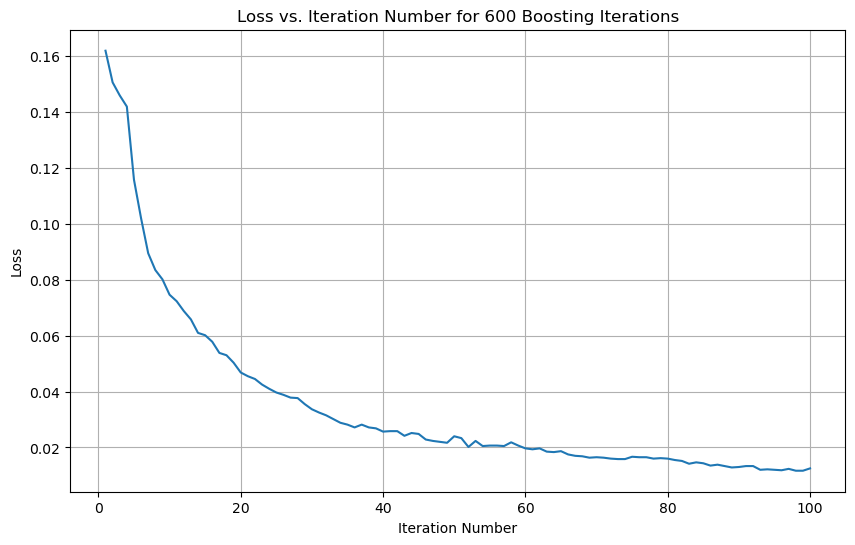

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,101), loss_v_iter)
plt.ylabel('Loss')
plt.xlabel('Iteration Number')
plt.title('Loss vs. Iteration Number for 600 Boosting Iterations')
plt.grid()
plt.show()

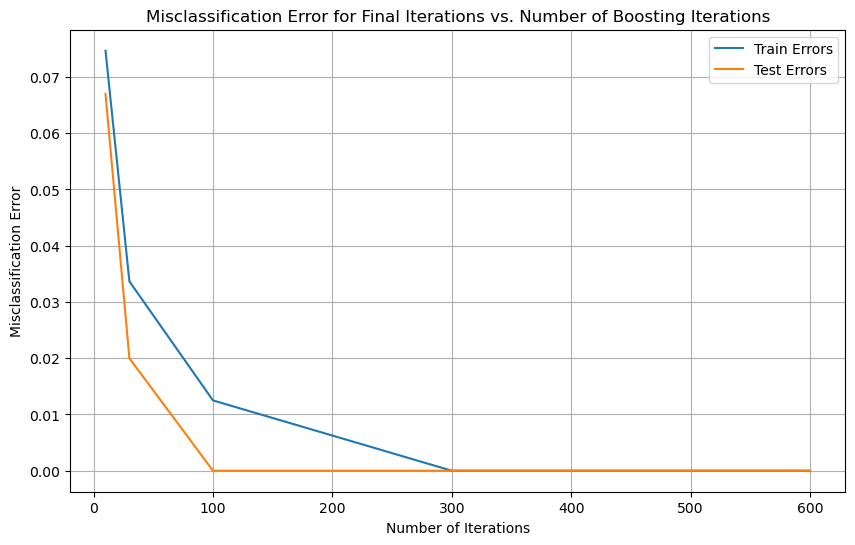

In [13]:
plt.figure(figsize=(10,6))
plt.plot([10,30,100,300,600], train_errors, label = 'Train Errors')
plt.plot([10,30,100,300,600], test_errors, label = 'Test Errors')
plt.title('Misclassification Error for Final Iterations vs. Number of Boosting Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend()
plt.show()

In [14]:
fpr_train, tpr_train, _ = roc_curve(y, prob_300)
fpr_test, tpr_test, _ = roc_curve(yt, prob_300t)

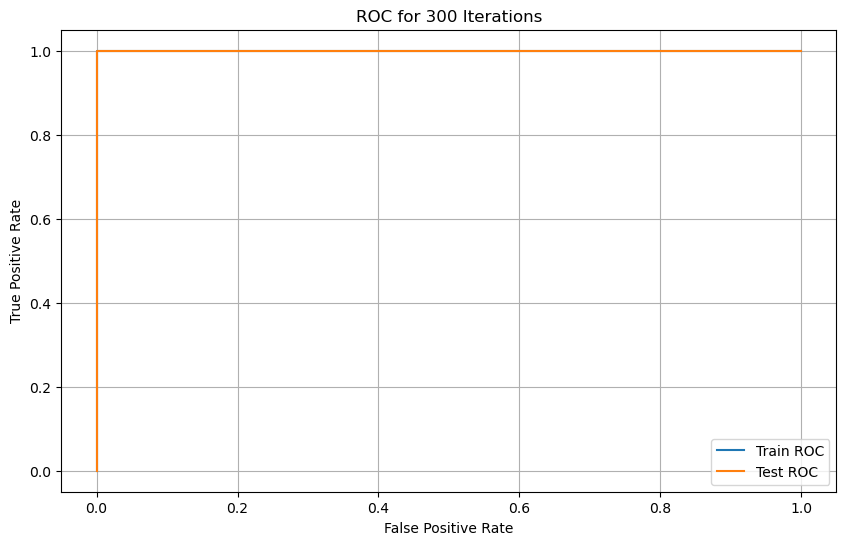

In [15]:
plt.figure(figsize=(10,6))
plt.plot(fpr_train, tpr_train, label= 'Train ROC')
plt.plot(fpr_test, tpr_test, label = 'Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for 300 Iterations')
plt.grid()
plt.legend()
plt.show()

# Dexter dataset

In [16]:
X = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Dexter\dexter_train.csv', header= None)
y = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Dexter\dexter_train.labels', header = None)
Xt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Dexter\dexter_valid.csv', header= None, dtype = np.float64)
yt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Dexter\dexter_valid.labels', header = None)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xts = scaler.transform(Xt)

Xs = np.hstack([np.ones((Xs.shape[0], 1)), Xs])
Xts = np.hstack([np.ones((Xts.shape[0], 1)), Xts])

y = np.where(y == -1, 0, 1)
yt = np.where(yt == -1, 0, 1)

In [17]:
train_errors = []
prob_300 = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xs, y , i, weak_learners)
    train_errors.append(1-s)
    if i == 300:
        prob_300 = get_proba(Xs)
print(train_errors)

[0.07333333333333336, 0.0033333333333332993, 0.0, 0.0, 0.0]


In [18]:
test_errors = []
prob_300t = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xts, yt , i, weak_learners)
    test_errors.append(1-s)
    if i == 300:
        prob_300t = get_proba(Xts)
print(test_errors)

C:\Users\evans\AppData\Local\Temp\ipykernel_33240\4149781114.py:17: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(-yb.reshape(-1,1)*new_h)), axis = 0)


[0.09333333333333338, 0.013333333333333308, 0.0, 0.0, 0.0]


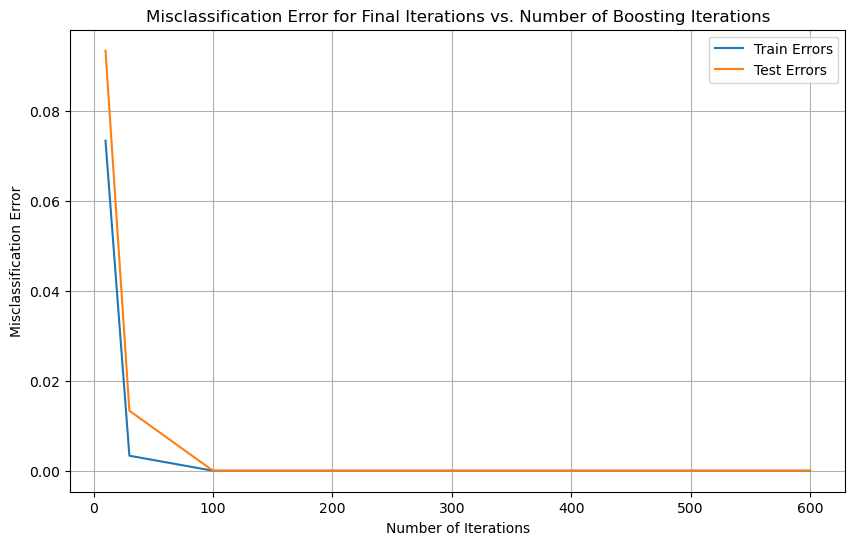

In [19]:
plt.figure(figsize=(10,6))
plt.plot([10,30,100,300,600], train_errors, label = 'Train Errors')
plt.plot([10,30,100,300,600], test_errors, label = 'Test Errors')
plt.title('Misclassification Error for Final Iterations vs. Number of Boosting Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend()
plt.show()

In [20]:
weak_learners = []
loss_v_iter = lossviter(Xs, y, weak_learners)

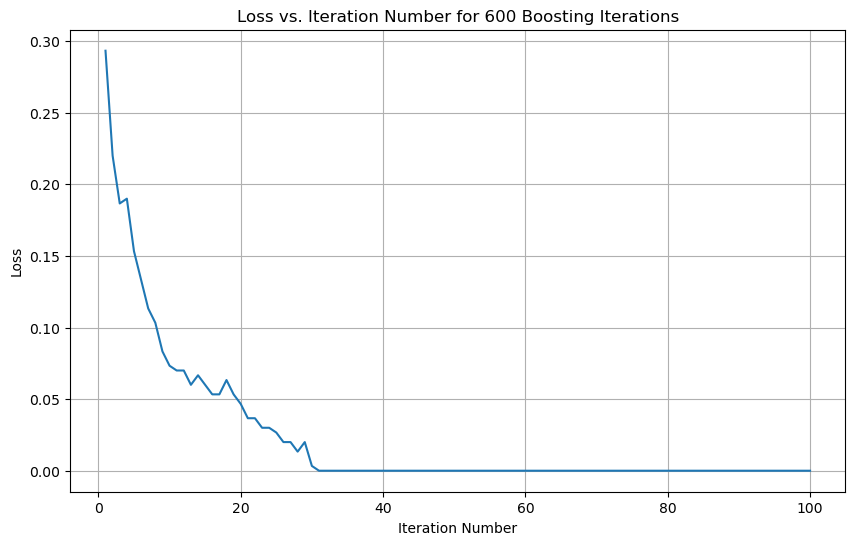

In [21]:
plt.figure(figsize=(10,6))
plt.plot(range(1,101), loss_v_iter)
plt.ylabel('Loss')
plt.xlabel('Iteration Number')
plt.title('Loss vs. Iteration Number for 600 Boosting Iterations')
plt.grid()
plt.show()

In [22]:
fpr_train, tpr_train, _ = roc_curve(y, prob_300)
fpr_test, tpr_test, _ = roc_curve(yt, prob_300t)

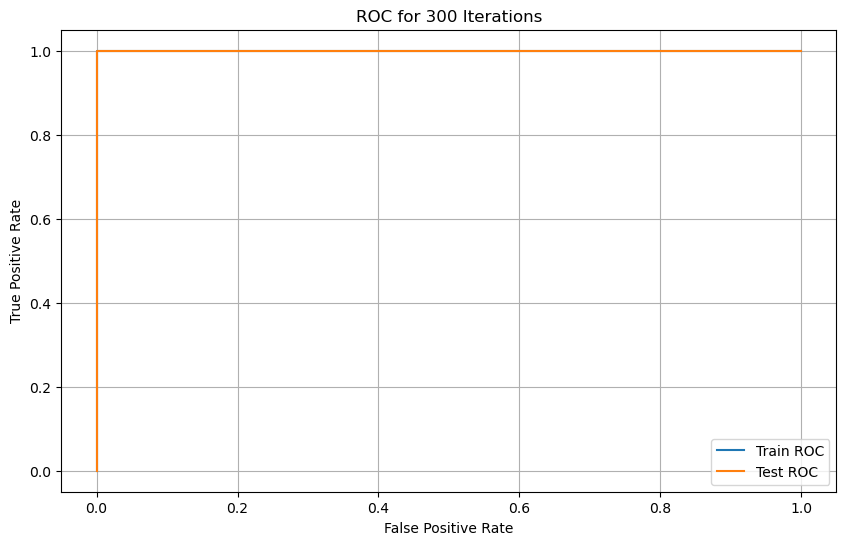

In [23]:
plt.figure(figsize=(10,6))
plt.plot(fpr_train, tpr_train, label= 'Train ROC')
plt.plot(fpr_test, tpr_test, label = 'Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for 300 Iterations')
plt.grid()
plt.legend()
plt.show()

# Arcene dataset

In [30]:
X = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Arcene/arcene_train.data', header= None, sep = ' ')
y = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Arcene/arcene_train.labels', header = None)
Xt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Arcene/arcene_valid.data', header= None, sep = ' ')
yt = pd.read_csv('D:\School\Applied ML FSU\Applied-ML-FSU\Data\Arcene/arcene_valid.labels', header = None)

X = X.drop(10000, axis = 1)
Xt = Xt.drop(10000, axis = 1)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xts = scaler.transform(Xt)

Xs = np.hstack([np.ones((Xs.shape[0], 1)), Xs])
Xts = np.hstack([np.ones((Xts.shape[0], 1)), Xts])

y = np.where(y == -1, 0, 1)
yt = np.where(yt == -1, 0, 1)

In [32]:
train_errors = []
prob_300 = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xs, y , i, weak_learners)
    train_errors.append(1-s)
    if i == 300:
        prob_300 = get_proba(Xs)
print(train_errors)

[0.0, 0.0, 0.0, 0.0, 0.0]


In [33]:
test_errors = []
prob_300t = 0
for i in [10,30,100,300,600]:
    weak_learners = []
    s = Lgboost(Xts, yt , i, weak_learners)
    test_errors.append(1-s)
    if i == 300:
        prob_300t = get_proba(Xts)
print(test_errors)

C:\Users\evans\AppData\Local\Temp\ipykernel_33240\4149781114.py:17: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(-yb.reshape(-1,1)*new_h)), axis = 0)


[0.010000000000000009, 0.0, 0.0, 0.0, 0.0]


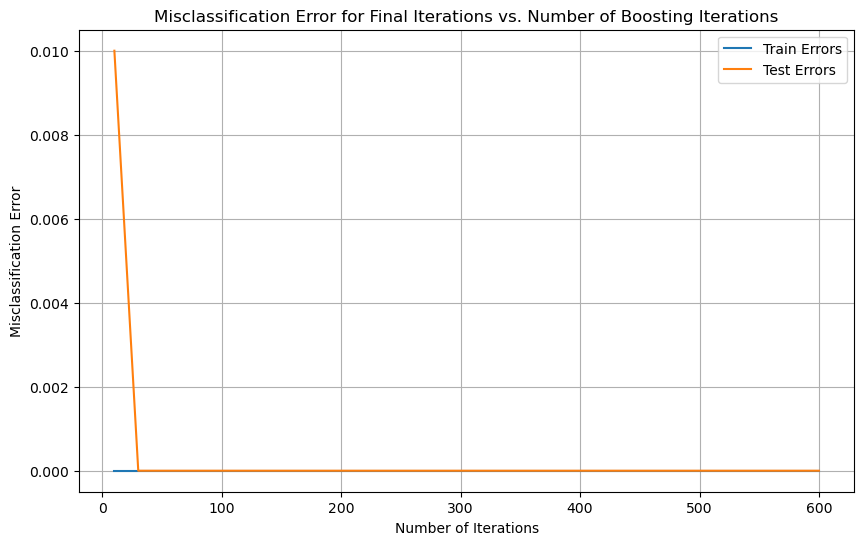

In [34]:
plt.figure(figsize=(10,6))
plt.plot([10,30,100,300,600], train_errors, label = 'Train Errors')
plt.plot([10,30,100,300,600], test_errors, label = 'Test Errors')
plt.title('Misclassification Error for Final Iterations vs. Number of Boosting Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend()
plt.show()

In [35]:
weak_learners = []
loss_v_iter = lossviter(Xs, y, weak_learners)

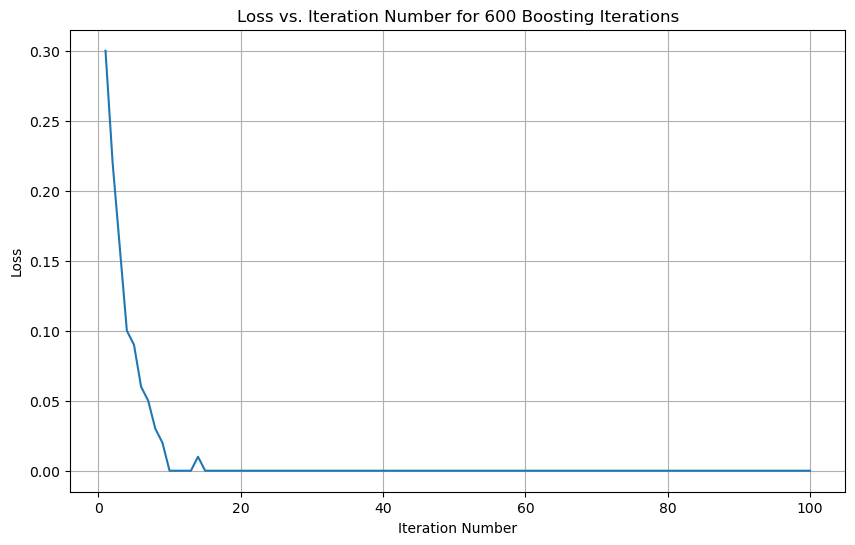

In [36]:
plt.figure(figsize=(10,6))
plt.plot(range(1,101), loss_v_iter)
plt.ylabel('Loss')
plt.xlabel('Iteration Number')
plt.title('Loss vs. Iteration Number for 600 Boosting Iterations')
plt.grid()
plt.show()

In [37]:
fpr_train, tpr_train, _ = roc_curve(y, prob_300)
fpr_test, tpr_test, _ = roc_curve(yt, prob_300t)

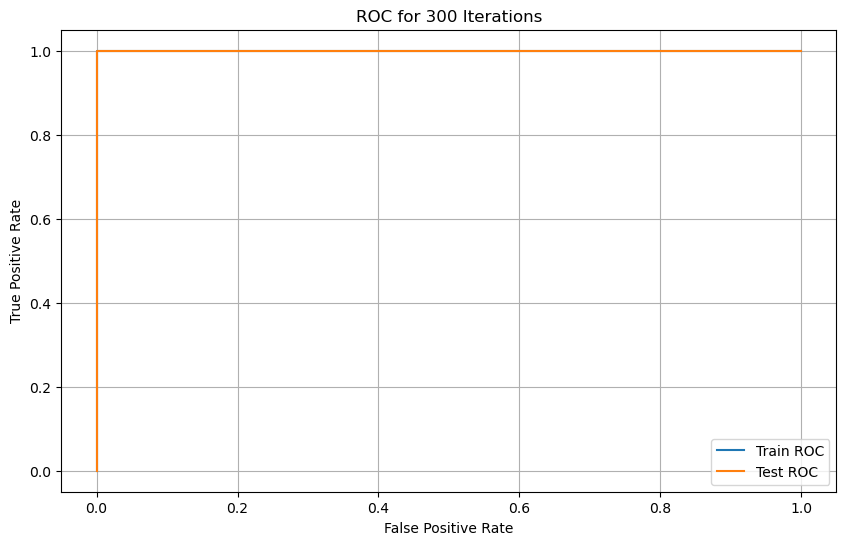

In [38]:
plt.figure(figsize=(10,6))
plt.plot(fpr_train, tpr_train, label= 'Train ROC')
plt.plot(fpr_test, tpr_test, label = 'Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for 300 Iterations')
plt.grid()
plt.legend()
plt.show()